In [1]:
from Pipeline import BLEPipeline

# General data processing
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt

# ML libraries
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, confusion_matrix, matthews_corrcoef
from sklearn.model_selection import GridSearchCV, KFold, cross_val_score

# System libraries
import itertools
import random, time

# Warning filtering
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
plt.rcParams.update({'figure.max_open_warning': 0})

# Define functions

In [2]:
def run_multiclass(df_train, df_test, features_list, y_list):
    # Initialize classifiers using tuned hyperparameters
    knn = KNeighborsClassifier(n_neighbors=5)
    lda = LinearDiscriminantAnalysis(n_components=1)
    rf = RandomForestClassifier(max_features=7)  
    
    # Train classifiers
    knn_model = knn.fit(df_train[features_list], df_train['DeviceType'])
    lda_model = lda.fit(df_train[features_list], df_train['DeviceType'])
    rf_model = rf.fit(df_train[features_list], df_train['DeviceType'])
    
    # Test classifiers
    knn_preds = knn_model.predict(df_test[features_list])
    lda_preds = lda_model.predict(df_test[features_list])
    rf_preds = rf_model.predict(df_test[features_list])
    
    preds = dict(knn=knn_preds, lda=lda_preds, rf=rf_preds)
    
    # Score classifiers
    metrics = {}
    conf_matrices = {}
    for classifier,pred in preds.iteritems():
        bacc = balanced_accuracy_score(df_test['DeviceType'], pred)
        prec = precision_score(df_test['DeviceType'], pred, average=None)
        recall = recall_score(df_test['DeviceType'], pred, average=None)
        mc = matthews_corrcoef(df_test['DeviceType'], pred)
        
        conf_matrices[classifier] = confusion_matrix(df_test['DeviceType'], pred, labels=y_list)
        metrics[classifier] = bacc, prec, recall, mc
    
    return preds, metrics, conf_matrices

In [3]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

# Create, process dataframe

In [4]:
b = BLEPipeline()

In [5]:
df = b.make_dataframe()

August2    210644
Home1       54902
Home2       54516
Push        30661
Kevo        19430
August1     15047
Weather      8101
Room2        7698
Room1        7239
Door1        6696
Door2        3587
Name: Name, dtype: int64


# Prep multiclass classifiers

In [6]:
# BLE: Define which features to use
features_list = [
    # Packet info
    "PacketLength", "BLE_LL_Length",
    
    # Associate Packets
    "Assoc_Packets",
    
    # Channel number
    "Channel_0", "Channel_12", "Channel_39",
    
    # PDU Type
    "SCAN_RSP", "ADV_IND", "SCAN_REQ", 
    "CONNECT_REQ", "ADV_NONCONN_IND", "ADV_DIRECT_IND"]

y_list = ["door", "lock", "temp"]

In [7]:
# Divide training and test sets
df_train = df[df['Set']=='train']
df_test = df[df['Set']=='test']

print df_train['DeviceType'].value_counts(), "\n"
print df_test['DeviceType'].value_counts()

door    116114
temp     46001
lock     34477
Name: DeviceType, dtype: int64 

lock    210644
temp      7698
door      3587
Name: DeviceType, dtype: int64


# Run multiclass

In [8]:
preds, metrics, cms = run_multiclass(df_train, df_test, features_list, y_list)

# Report results

## Report confusion matrices

Confusion matrix, without normalization
[[    46      0   3541]
 [ 17419 193225      0]
 [   103      0   7595]]


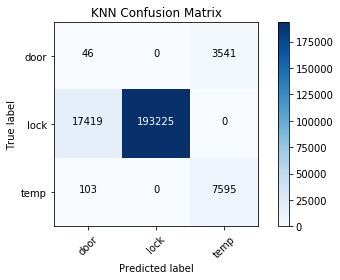

In [9]:
classifier = 'knn'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix' ,normalize=False);

Confusion matrix, without normalization
[[     1   3586      0]
 [210639      5      0]
 [     1   7697      0]]


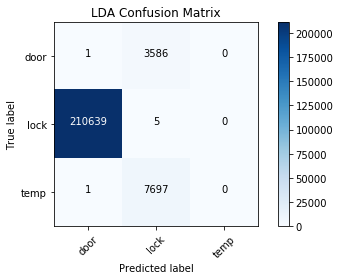

In [10]:
classifier = 'lda'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix' ,normalize=False);

Confusion matrix, without normalization
[[    47      1   3539]
 [210640      4      0]
 [   100      0   7598]]


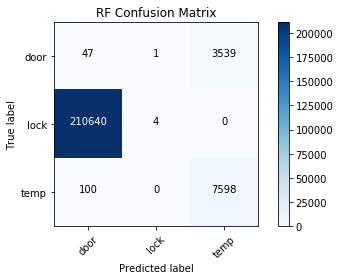

In [11]:
classifier = 'rf'
plot_confusion_matrix(cms[classifier], classes=y_list, title=classifier.upper() + ' Confusion Matrix' ,normalize=False);

## Report metrics

In [12]:
metrics_df = pd.DataFrame()

# Extract metrics and put into dataframe
for k,v in metrics.iteritems():
    bacc = pd.Series({'BACC':v[0]},name=k)
    prec = pd.Series(v[1],index=['Prec_Door', 'Prec_Lock', 'Prec_Temp'], name=k)
    recall = pd.Series(v[2],index=['Recall_Door', 'Recall_Lock', 'Recall_Temp'], name=k)
    mattcorr = pd.Series({'Matt_Corr':v[3]},name=k)
    metric_series = pd.concat([bacc,prec, recall, mattcorr])
    metrics_df = pd.concat([metrics_df,metric_series], axis=1)
metrics_df = metrics_df.T

# Print to csv
metrics_df.to_csv('Results/ble-multiclass_metrics.csv', mode='w')

# Residuals Analysis